# Problem Statement
In this assignment students have to make ARIMA model over shampoo sales data and check the MSE between predicted and actual value.

In [1]:
## Importing Libraries
from pandas import read_csv
from pandas import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
def dateconverter(x):
    m = x.split('-')[0]
    if len(m) < 2:
        return datetime.strptime('190'+x,'%Y-%m')
    else:
        return datetime.strptime('19'+x,'%Y-%m')
    
## Reading dataset
shampoo_df=pd.read_csv('sales-of-shampoo-over-a-three-ye.csv')

## removing last row
shampoo_df.drop(index=36,inplace=True)

shampoo_df['Month'] = shampoo_df['Month'].apply(lambda x : dateconverter(x))

In [3]:
shampoo_df.columns=['Month','Sales']
shampoo_df.head()

,Month,Sales
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


In [4]:
##Changing index as Month
shampoo_df.set_index('Month',inplace=True)
shampoo_df.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


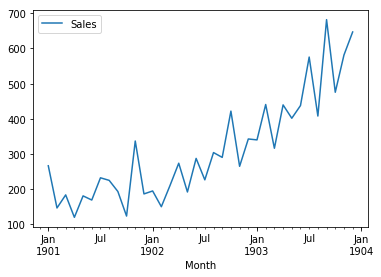

In [5]:
shampoo_df.plot()

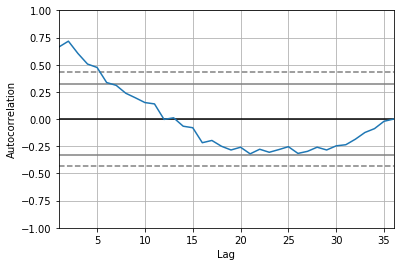

In [6]:
## Autocorrelation plot of the time series
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(shampoo_df)

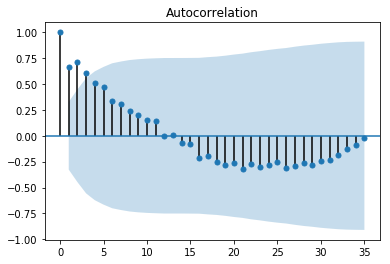

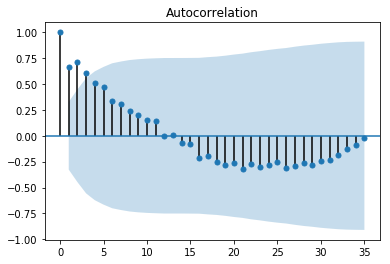

In [7]:
## Stationarity Check
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(shampoo_df)

In [8]:
## Auto correlation is decreasing gradually indicating that it is not a stationary data


In [9]:
timeseries = shampoo_df['Sales']
timeseries.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01', '1901-11-01', '1901-12-01',
               '1902-01-01', '1902-02-01', '1902-03-01', '1902-04-01',
               '1902-05-01', '1902-06-01', '1902-07-01', '1902-08-01',
               '1902-09-01', '1902-10-01', '1902-11-01', '1902-12-01',
               '1903-01-01', '1903-02-01', '1903-03-01', '1903-04-01',
               '1903-05-01', '1903-06-01', '1903-07-01', '1903-08-01',
               '1903-09-01', '1903-10-01', '1903-11-01', '1903-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

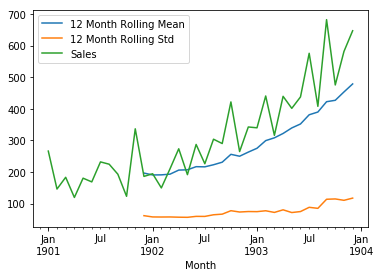

In [10]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

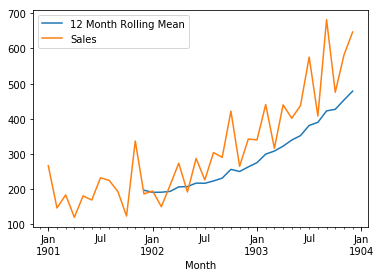

In [11]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

In [12]:
# Dickey-Fuller Test Function
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [13]:
## Checking Stationarity using DF test
adf_check(shampoo_df['Sales'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : 3.0601420836411806
p-value : 1.0
#Lags Used : 10
Number of Observations Used : 25
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [14]:
##We have now realized that our data is seasonal (it is also pretty obvious from the plot itself). 
##This means we need to use Seasonal ARIMA on our model.

In [15]:
## Differencing
shampoo_df['Sales_first_diff']=shampoo_df['Sales']-shampoo_df['Sales'].shift(1)
shampoo_df.head()

,Sales,Sales_first_diff
Month,,
1901-01-01,266.0,NaN
1901-02-01,145.9,-120.1
1901-03-01,183.1,37.2
1901-04-01,119.3,-63.8
1901-05-01,180.3,61.0


In [16]:
## Appliying DF test to first diff
adf_check(shampoo_df['Sales_first_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.249074055553854
p-value : 1.7998574141687034e-10
#Lags Used : 1
Number of Observations Used : 33
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


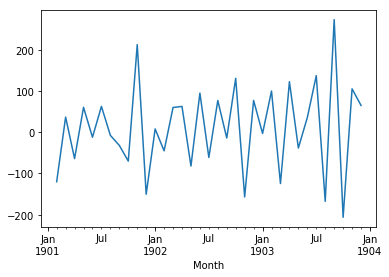

In [17]:
shampoo_df['Sales_first_diff'].plot()

In [18]:
## Seasonal Difference
shampoo_df['Sales_seasonal_diff']=shampoo_df['Sales']-shampoo_df['Sales'].shift(12)
shampoo_df.head()

,Sales,Sales_first_diff,Sales_seasonal_diff
Month,,,
1901-01-01,266.0,NaN,NaN
1901-02-01,145.9,-120.1,NaN
1901-03-01,183.1,37.2,NaN
1901-04-01,119.3,-63.8,NaN
1901-05-01,180.3,61.0,NaN


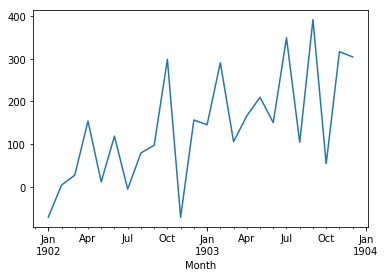

In [19]:
shampoo_df['Sales_seasonal_diff'].plot()

In [20]:
## Appliying DF test to Seasonal diff
adf_check(shampoo_df['Sales_seasonal_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.04561553414249077
p-value : 0.9545931714075298
#Lags Used : 6
Number of Observations Used : 17
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


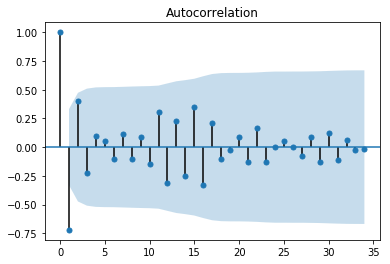

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig_first = plot_acf(shampoo_df["Sales_first_diff"].dropna())


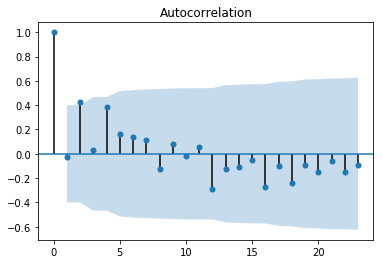

In [22]:
fig_first = plot_acf(shampoo_df["Sales_seasonal_diff"].dropna())

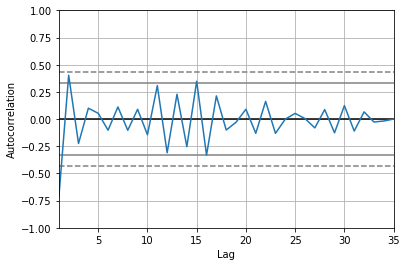

In [23]:
autocorrelation_plot(shampoo_df['Sales_first_diff'].dropna())

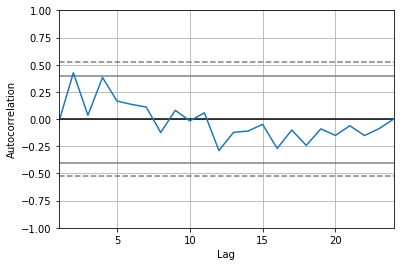

In [24]:
autocorrelation_plot(shampoo_df['Sales_seasonal_diff'].dropna())

In [25]:

# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Mon, 15 Apr 2019   AIC                            406.340
Time:                        19:48:46   BIC                            417.227
Sample:                             1   HQIC                           410.098
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.y     -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.y     -0.6203      0.282     -2.203      0.0

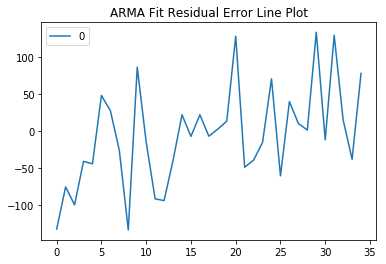

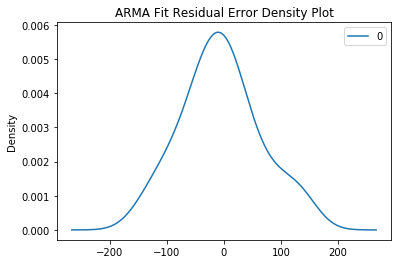

                0
count   35.000000
mean    -5.495218
std     68.132882
min   -133.296637
25%    -42.477890
50%     -7.186512
75%     24.748330
max    133.237936


In [26]:
# fit model
model = ARIMA(shampoo_df['Sales'].values, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('ARMA Fit Residual Error Line Plot')
plt.show()
residuals.plot(kind='kde')
plt.title('ARMA Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

predicted=349.117712, expected=342.300000
predicted=306.512952, expected=339.700000
predicted=387.376449, expected=440.400000
predicted=348.154255, expected=315.900000
predicted=386.308818, expected=439.300000
predicted=356.082087, expected=401.300000
predicted=446.379462, expected=437.400000
predicted=394.737224, expected=575.500000
predicted=434.915402, expected=407.600000
predicted=507.923547, expected=682.000000
predicted=435.482779, expected=475.300000
predicted=652.743826, expected=581.300000
predicted=546.343519, expected=646.900000

-------------------------------------------------------------
Test MSE : 6958.324

-------------------------------------------------------------


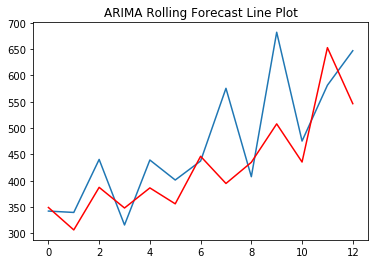

In [27]:
X = shampoo_df['Sales'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('\n-------------------------------------------------------------')
print('Test MSE : %.3f' % error)
print('\n-------------------------------------------------------------')
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('ARIMA Rolling Forecast Line Plot')
plt.show()